### 7.1 Symmetric Cusum Filter on Revenue

In [1]:
# In pypm.filters
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def calculate_non_uniform_lagged_change(series: pd.Series, n_days: int):
    """
    Use pd.Series.searchsorted to measure the lagged change in a non-uniformly 
    spaced time series over n_days of calendar time. 
    """

    # Get mapping from now to n_days ago at every point
    _timedelta: pd.Timedelta = pd.Timedelta(days=n_days)
    _idx: pd.Series = series.index.searchsorted(series.index - _timedelta)
    _idx = _idx[_idx > 0]

    # Get the last len(series) - n_days values
    _series = series.iloc[-_idx.shape[0]:]

    # Build a padding of NA values
    _pad_length = series.shape[0] - _idx.shape[0]
    _na_pad = pd.Series(None, index=series.index[:_pad_length])

    # Get the corresonding lagged values
    _lagged_series = series.iloc[_idx]

    # Measure the difference
    _diff = pd.Series(_series.values-_lagged_series.values, index=_series.index)

    return pd.concat([_na_pad, _diff])

In [3]:
def calculate_cusum_events(series: pd.Series, 
    filter_threshold: float) -> pd.DatetimeIndex:
    """
    Calculate symmetric cusum filter and corresponding events
    """

    event_dates = list()
    s_up = 0
    s_down = 0

    for date, price in series.items():
        s_up = max(0, s_up + price)
        s_down = min(0, s_down + price)

        if s_up > filter_threshold:
            s_up = 0
            event_dates.append(date)

        elif s_down < -filter_threshold:
            s_down = 0
            event_dates.append(date)

    return pd.DatetimeIndex(event_dates)

In [4]:
# load path
import sys
if "src/" not in sys.path:
    sys.path.append("src/")

# In pypm.ml_model.events
from pypm import filters

In [5]:
def calculate_events_for_revenue_series(series: pd.Series, 
    filter_threshold: float, lookback: int=365) -> pd.DatetimeIndex:
    """
    Calculate the symmetric cusum filter to generate events on YoY changes in 
    the log revenue series
    """
    series = np.log(series)
    series = filters.calculate_non_uniform_lagged_change(series, lookback)
    return filters.calculate_cusum_events(series, filter_threshold)

In [6]:
def calculate_events(revenue_series: pd.Series):
    return calculate_events_for_revenue_series(
        revenue_series,
        filter_threshold=5,
        lookback=365,
    )

### 7.2 Computing Triple Barrier Labels

In [7]:
# See pypm.labels
import numpy as np
import pandas as pd
from typing import Tuple

In [8]:
def compute_triple_barrier_labels(
    price_series: pd.Series, 
    event_index: pd.Series, 
    time_delta_days: int, 
    upper_delta: float=None, 
    lower_delta: float=None, 
    vol_span: int=20, 
    upper_z: float=None,
    lower_z: float=None,
    upper_label: int=1, 
    lower_label: int=-1) -> Tuple[pd.Series, pd.Series]:
    """
    Calculate event labels according to the triple-barrier method. 

    Return a series with both the original events and the labels. Labels 1, 0, 
    and -1 correspond to upper barrier breach, vertical barrier breach, and 
    lower barrier breach, respectively. 

    Also return series where the index is the start date of the label and the 
    values are the end dates of the label.
    """

    timedelta = pd.Timedelta(days=time_delta_days)
    series = pd.Series(np.log(price_series.values), index=price_series.index)

    # A list with elements of {-1, 0, 1} indicating the outcome of the events
    labels = list()
    label_dates = list()

    if upper_z or lower_z:
        volatility = series.ewm(span=vol_span).std()
        volatility *= np.sqrt(time_delta_days / vol_span)

    for event_date in event_index:
        date_barrier = event_date + timedelta

        start_price = series.loc[event_date]
        log_returns = series.loc[event_date:date_barrier] - start_price

        # First element of tuple is 1 or -1 indicating upper or lower barrier
        # Second element of tuple is first date when barrier was crossed
        candidates: List[Tuple[int, pd.Timestamp]] = list()

        # Add the first upper or lower delta crosses to candidates
        if upper_delta:
            _date = log_returns[log_returns > upper_delta].first_valid_index()
            if _date:
                candidates.append((upper_label, _date))
    
        if lower_delta:
            _date = log_returns[log_returns < lower_delta].first_valid_index()
            if _date:
                candidates.append((lower_label, _date))

        # Add the first upper_z and lower_z crosses to candidates
        if upper_z:
            upper_barrier = upper_z * volatility[event_date]
            _date = log_returns[log_returns > upper_barrier].first_valid_index()
            if _date:
                candidates.append((upper_label, _date))

        if lower_z:
            lower_barrier = lower_z * volatility[event_date]
            _date = log_returns[log_returns < lower_barrier].first_valid_index()
            if _date:
                candidates.append((lower_label, _date))

        if candidates:
            # If any candidates, return label for first date
            label, label_date = min(candidates, key=lambda x: x[1])
        else:
            # If there were no candidates, time barrier was touched
            label, label_date = 0, date_barrier

        labels.append(label)
        label_dates.append(label_date)

    label_series = pd.Series(labels, index=event_index)
    event_spans = pd.Series(label_dates, index=event_index)

    return label_series, event_spans

In [9]:
# See pypm.ml_model.labels
from typing import Tuple
from pypm import labels

In [10]:
def calculate_labels(price_series, event_index) -> Tuple[pd.Series, pd.Series]:
    """
    Calculate labels based on the triple barrier method. Return a series of 
    event labels index by event start date, and return a series of event end 
    dates indexed by event start date.
    """

    # Remove event that don't have a proper chance to materialize
    time_delta_days = 90
    max_date = price_series.index.max()
    cutoff = max_date - pd.Timedelta(days=time_delta_days)
    event_index = event_index[event_index <= cutoff]

    # Use triple barrier method
    event_labels, event_spans = labels.compute_triple_barrier_labels(
        price_series,
        event_index,
        time_delta_days=time_delta_days,
        upper_z=1.8,
        lower_z=-1.8,
    )

    return event_labels, event_spans

### 7.3 Computing Average Uniqueness

In [11]:
# See pypm.weights
import numpy as np
import pandas as pd
from scipy.stats import hmean

In [12]:
def calculate_uniqueness(event_spans: pd.Series, 
    price_index: pd.Series) -> pd.Series:
    """
    event_spans is a series with an index of start dates and values of end dates
    of a label.

    price_index is an index of underlying dates for the event

    Returns a series of uniqueness values that can be used as weights, indexed 
    as the event start dates. Weights may need to be standardized again before 
    training.
    """

    # Create a binary data frame 
    # value is 1 during event span and 0 otherwise
    columns = range(event_spans.shape[0])
    df = pd.DataFrame(0, index=price_index, columns=columns)

    for i, (event_start, event_end) in enumerate(event_spans.items()):
        df[i].loc[event_start:event_end] += 1

    # Compute concurrency over event span then calculate uniqueness
    uniquenesses = list()
    for i, (event_start, event_end) in enumerate(event_spans.items()):
        concurrency: pd.Series = df.loc[event_start:event_end].sum(axis=1)
        uniqueness = 1 / hmean(concurrency)
        uniquenesses.append(uniqueness)

    return pd.Series(uniquenesses, index=event_spans.index)

In [13]:
# See pypm.ml_model.weights
import numpy as np
import pandas as pd

from pypm.weights import calculate_uniqueness

In [14]:
def calculate_weights(event_spans: pd.Series, 
    price_index: pd.Series) -> pd.Series:
    return calculate_uniqueness(event_spans, price_index)

### 7.4 Computing Features

In [15]:
import numpy as np
import pandas as pd

from pypm import indicators, filters, metrics

In [16]:
_calc_delta = filters.calculate_non_uniform_lagged_change
_calc_ma = indicators.calculate_simple_moving_average
_calc_log_return = metrics.calculate_log_return_series

In [17]:
def _calc_rolling_vol(series, n):
    return series.rolling(n).std() * np.sqrt(252 / n)

In [18]:
def calculate_features(price_series, revenue_series) -> pd.DataFrame:
    """
    Calculate any and all potentially useful features. Return as a dataframe.
    """

    log_revenue = np.log(revenue_series)
    log_prices = np.log(price_series)

    log_revenue_ma = _calc_ma(log_revenue, 10)
    log_prices_ma = _calc_ma(log_prices, 10)

    log_returns = _calc_log_return(price_series)

    features_by_name = dict()

    for i in [7, 30, 90, 180, 360]:

        rev_feature = _calc_delta(log_revenue_ma, i)
        price_feature = _calc_delta(log_prices_ma, i)
        vol_feature = _calc_rolling_vol(log_returns, i)

        features_by_name.update({
            f'{i}_day_revenue_delta': rev_feature,
            f'{i}_day_return': price_feature,
            f'{i}_day_vol': vol_feature,
        })

    features_df = pd.DataFrame(features_by_name)    
    return features_df

### 7.5 Modeling and Cross Validation

In [19]:
# See pypm.ml_model.model
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.base import clone

from joblib import Parallel, delayed

In [20]:
# Number of jobs to run in parallel
# Set to number of computer cores to use
N_JOBS = 10
N_SPLITS = 5
N_REPEATS = 4

In [21]:
def _fit_and_score(classifier, X, y, w, train_index, test_index, i) -> float:
    """
    The function used by joblib to split, train, and score cross validations
    """
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]

    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    w_train = w.iloc[train_index]
    w_test = w.iloc[test_index]

    classifier.fit(X_train, y_train, w_train)
    score = classifier.score(X_test, y_test, w_test)

    print(f'Finished {i} ({100*score:.1f}%)')

    return score

In [22]:
def repeated_k_fold(classifier, X, y, w) -> np.ndarray:
    """
    Perform repeated k-fold cross validation on a classifier. Spread fitting 
    job over multiple computer cores.
    """
    n_jobs = N_JOBS

    n_splits = N_SPLITS
    n_repeats = N_REPEATS

    total_fits =  n_splits * n_repeats

    _k_fold = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

    print(f'Fitting {total_fits} models {n_jobs} at a time ...')
    print()

    parallel = Parallel(n_jobs=n_jobs)
    scores = parallel(
        delayed(_fit_and_score)(
            clone(classifier), X, y, w, train_index, test_index, i
        ) for i, (train_index, test_index) in enumerate(_k_fold.split(X))
    )

    return np.array(scores)

In [23]:
def calculate_model(df: pd.DataFrame) -> RandomForestClassifier:
    """
    Given a dataframe with a y column, weights column, and predictor columns 
    with arbitrary names, cross-validated and fit a classifier. Print 
    diagnostics.
    """
    classifier = RandomForestClassifier(n_estimators=100)

    # Separate data
    predictor_columns = [
        c for c in df.columns.values if not c in ('y', 'weights')
    ]
    X = df[predictor_columns]
    y = df['y']
    w = df['weights']

    # Fit cross validation
    scores = repeated_k_fold(classifier, X, y, w)

    # Get a full dataset fit for importance scores
    classifier.fit(X, y, w)

    # Compute diagnostics
    _imp = classifier.feature_importances_
    importance_series = pd.Series(_imp, index=predictor_columns)
    importance_series = importance_series.sort_values(ascending=False)

    # baseline accuracy is the best value achievable with a constant guess
    baseline = np.max(y.value_counts() / y.shape[0])

    # Compute a rough confidence interval for the improvement
    mean_score = scores.mean()
    std_score = scores.std()

    upper_bound = mean_score + 2 * std_score
    lower_bound = mean_score - 2 * std_score
    ibounds = (lower_bound - baseline, upper_bound - baseline)

    print('Feature importances')
    for col, imp in importance_series.items():
        print(f'{col:24} {imp:>.3f}')
    print()

    print('Cross validation scores')
    print(np.round(100 * scores, 1))
    print()

    print(f'Baseline accuracy {100*baseline:.1f}%')
    print(f'OOS accuracy {100*mean_score:.1f}% +/- {200 * scores.std():.1f}%')
    print(f'Improvement {100*(ibounds[0]):.1f} to {100*(ibounds[1]):.1f}%')
    print()

    return classifier

### 7.6 Machine Learning Pipeline

In [24]:
# See fit_alternative_data_model.py
import os
import pandas as pd
import numpy as np
from typing import Dict

from joblib import dump

from pypm.ml_model.data_io import load_data
from pypm.ml_model.events import calculate_events
from pypm.ml_model.labels import calculate_labels
from pypm.ml_model.features import calculate_features
from pypm.ml_model.model import calculate_model
from pypm.ml_model.weights import calculate_weights

In [25]:
# SRC_DIR = os.path.dirname(os.path.abspath(__file__))
SRC_DIR = ""

In [26]:
# All the data we have to work with
symbols, eod_data, alt_data = load_data()

# The ML dataframe for each symbol, to be combined later
df_by_symbol: Dict[str, pd.DataFrame] = dict()

# Build ML dataframe for each symbol
for symbol in symbols:

    # Get revenue and price series
    revenue_series = alt_data[symbol].dropna()
    price_series = eod_data[symbol].dropna()
    price_index = price_series.index

    # Get events, labels, weights, and features
    event_index = calculate_events(revenue_series)
    event_labels, event_spans = calculate_labels(price_series, event_index)
    weights = calculate_weights(event_spans, price_index)
    features_df = calculate_features(price_series, revenue_series)

    # Subset features by event dates
    features_on_events = features_df.loc[event_index]

    # Convert labels and events to a data frame
    labels_df = pd.DataFrame(event_labels)
    labels_df.columns = ['y']

    # Converts weights to a data frame
    weights_df = pd.DataFrame(weights)
    weights_df.columns = ['weights']

    # Concatenate features to labels
    df = pd.concat([features_on_events, weights_df, labels_df], axis=1)
    df_by_symbol[symbol] = df

# Create final ML dataframe
df = pd.concat(df_by_symbol.values(), axis=0)
df.sort_index(inplace=True)
df.dropna(inplace=True)
print(df)

# Fit the model
classifier = calculate_model(df)

# Save the model
dump(classifier, os.path.join(SRC_DIR, 'ml_model.joblib'))

            7_day_revenue_delta  7_day_return  7_day_vol  \
2016-06-07            -0.000721      0.019520   0.096002   
2016-06-08             0.029827      0.025005   0.113246   
2016-06-08            -0.046427      0.013868   0.051878   
2016-06-09             0.001558      0.032410   0.064574   
2016-06-10             0.004933      0.011751   0.045105   
...                         ...           ...        ...   
2019-09-30            -0.031956     -0.008562   0.072845   
2019-10-01            -0.074244     -0.018469   0.053665   
2019-10-01             0.009513     -0.015659   0.094087   
2019-10-02             0.003023      0.015749   0.043320   
2019-10-02             0.012819     -0.008300   0.062938   

            30_day_revenue_delta  30_day_return  30_day_vol  \
2016-06-07              0.025643       0.033946    0.082937   
2016-06-08              0.063757      -0.011531    0.056490   
2016-06-08             -0.085587       0.021224    0.026436   
2016-06-09              0.0

['ml_model.joblib']

### 7.7 Simulation with Machine Learning Model

In [27]:
import pandas as pd
import numpy as np

import os
from joblib import load

from pypm.ml_model.data_io import load_data
from pypm.ml_model.signals import calculate_signals

from pypm import metrics, simulation

In [28]:
# SRC_DIR = os.path.dirname(os.path.abspath(__file__))
SRC_DIR = ""

In [29]:
def simulate_portfolio():

    # All the data we have to work with
    symbols, eod_data, alt_data = load_data()

    # Load classifier from file
    classifier = load(os.path.join(SRC_DIR, 'ml_model.joblib'))

    # Generate signals from classifier
    print('Calculating signals ...')
    signal = calculate_signals(classifier, symbols, eod_data, alt_data)

    # Get rid of eod_data before valid signals
    first_signal_date = signal.first_valid_index()
    eod_data = eod_data[eod_data.index > first_signal_date]

    # Set the preference to increase by row, so new trades are preferred
    print('Calculating preference matrix ...')
    preference = pd.DataFrame(
        np.random.random(eod_data.shape), 
        columns=eod_data.columns, 
        index=eod_data.index,
    )

    # Run the simulator
    simulator = simulation.SimpleSimulator(
        initial_cash=10000,
        max_active_positions=10,
        percent_slippage=0.0005,
        trade_fee=1,
    )
    simulator.simulate(eod_data, signal, preference)

    # Print results
    simulator.portfolio_history.print_position_summaries()
    simulator.print_initial_parameters()
    simulator.portfolio_history.print_summary()
    simulator.portfolio_history.plot()
    simulator.portfolio_history.plot_benchmark_comparison()

Calculating signals ...
Calculating preference matrix ...
VBB       Trade summary
Date:     Tue Jul 18, 2017 -> Tue Jul 25, 2017 [5 days]
Price:    $281.41 -> $290.6 [3.3%]
Value:    $997.07 -> $1029.63 [$32.56]

HECP      Trade summary
Date:     Tue Jul 11, 2017 -> Tue Jul 25, 2017 [10 days]
Price:    $1137.62 -> $1211.49 [6.5%]
Value:    $999.15 -> $1064.03 [$64.88]

KGO       Trade summary
Date:     Thu Jul 13, 2017 -> Wed Jul 26, 2017 [9 days]
Price:    $95.9 -> $97.74 [1.9%]
Value:    $998.57 -> $1017.75 [$19.18]

EHH       Trade summary
Date:     Fri Jul 07, 2017 -> Thu Jul 27, 2017 [14 days]
Price:    $274.33 -> $300.76 [9.6%]
Value:    $999.66 -> $1095.99 [$96.32]

LJGB      Trade summary
Date:     Mon Jul 17, 2017 -> Mon Jul 31, 2017 [10 days]
Price:    $249.3 -> $259.16 [4.0%]
Value:    $998.07 -> $1037.53 [$39.46]

SLRR      Trade summary
Date:     Thu Jul 27, 2017 -> Tue Aug 01, 2017 [3 days]
Price:    $239.44 -> $243.41 [1.7%]
Value:    $1094.44 -> $1112.59 [$18.15]

UTQ  

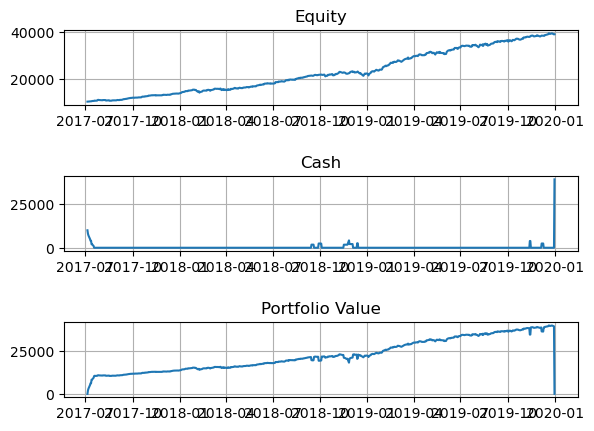

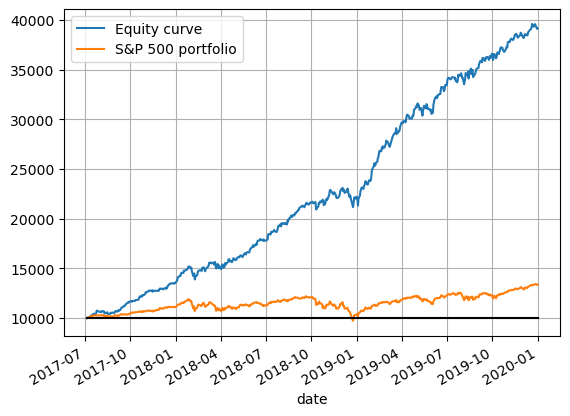

In [30]:
simulate_portfolio()